# SwinIR

### Short explanation of code

- The code is still unstructured and misses some minor parts. The functions should be organized in a separate file. SSIM is missing for evaluation.

- **Data representation:** We assume the data to have the info of the positions. Since we don't have that info yet available, there is a function that is currently commented out (Create new data part) where one can specify the data folder and then a new one is generated with the naming convention. Unfortunately, the detection of the person doesn't work, so it is ignored in the training process. The dataset class however already takes in this information.

- **Models:** I've tried out SwinIR and SwinIR V2. The first one, so SwinIR, takes about half the time for training.

- **Hyperparameters:** I had to set embed_dim = 48, because my machine crashes otherwise. Originally 96 was used for that. One could also play around with depths and num_heads.

- **Training:** Please execute either one of the parts. The model is saved every 100 iterations. After every evaluation step the first 5 samples, so 10 images, are saved to the 

- **Results:** Since the training took so long I could only process ~500 iterations, so 1000 samples and the results are not good. One can barely notice a better performance.

- **Idea:** I'll try setting the hyperparameter embed_dim = 96 and reduce depths and num_heads. This way the number of parameters is somewhat ok and hopefully the performance incrases.

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import cv2
import os
from glob import glob
from torch.utils.data import DataLoader, Dataset, random_split, Subset
from torchvision.transforms.functional import to_tensor
from pathlib import Path
from tqdm import trange
import random
import glob
from pathlib import Path
from skimage.measure import label, regionprops
from skimage import io
import time
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import logging

from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim

from dataset import FocalDataset

## Inspect Data

sample id: 9
input shape: [1, 512, 512]
ground truth shape: [1, 512, 512]


Text(0.5, 1.0, 'Ground Truth')

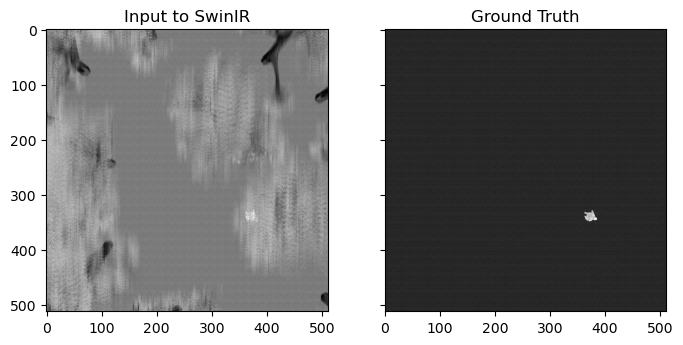

In [2]:
sample_idx_plotting = 9

print(f'sample id: {sample_idx_plotting}')

ds = FocalDataset(used_focal_lengths_idx=list(range(8)), augment=True)

inp, gt = ds[sample_idx_plotting]
inp = inp[4]

print(f'input shape: {list(inp.shape)}')
print(f'ground truth shape: {list(gt.shape)}')

def tens2img(tensor):
    '''Move the axes of a 3D Tensor such that it can be plotted as an image'''
    return np.moveaxis(tensor.detach().cpu().numpy(), 0,-1)

fig, axes = plt.subplots(1, 2, figsize=(8,4), sharey=True)

axes[0].imshow(tens2img(inp), cmap='gray')
axes[1].imshow(tens2img(gt), cmap='gray')

axes[0].set_title('Input to SwinIR')
axes[1].set_title('Ground Truth')

### Create new data

In [3]:
'''def detect_person(image, threshold=200, min_area=30):
    # Apply a threshold to create a binary image
    binary_image = image > threshold
    
    # Label connected regions
    labeled_img = label(binary_image)
    
    # Find properties of labeled regions
    regions = regionprops(labeled_img, intensity_image=image)
    
    # Assume no person is present by default
    person_present = False
    xpos, ypos = 0, 0
    
    for region in regions:
        if region.area >= min_area:
            person_present = True
            ypos, xpos = region.centroid  # Note: regionprops uses (row, col) order
            break
    
    return person_present, (int(xpos), int(ypos))

    
def process_tiff_stack(input_folder, output_folder):
    input_path = Path(input_folder)
    output_path = Path(output_folder)
    output_path.mkdir(parents=True, exist_ok=True)  # Create output folder if it doesn't exist

    for tiff_file in input_path.glob('*.tiff'):
        # Load the TIFF stack
        stack = io.imread(tiff_file, plugin="tifffile")

        # Take the average across all images in the stack
        avg_image = np.mean(stack, axis=0).astype(np.uint8)
        
        # Save the average image as PNG
        avg_image_path = output_path / (tiff_file.stem + '.png')
        cv2.imwrite(str(avg_image_path), avg_image)

        # The corresponding ground truth filename is based on the TIFF filename
        gt_filename = tiff_file.stem[:-len('_integral')] + '_gt.png'
        gt_file = input_path / gt_filename

        # Initialize variables for person detection
        person_present = False
        xpos, ypos = 0, 0

        # Check for the existence of the ground truth file
        if gt_file.exists():
            gt_image = cv2.imread(str(gt_file), cv2.IMREAD_GRAYSCALE)
            if gt_image is not None:
                # Detect the person's position or set default (0, 0)
                person_present, (xpos, ypos) = detect_person(gt_image)

            # Construct new GT filename
            gt_suffix = f'_{xpos:03d}_{ypos:03d}_gt.png' if person_present else '_0000_0000_gt.png'
            new_gt_filename = tiff_file.stem[:-len('_integral')] + gt_suffix
            new_gt_path = output_path / new_gt_filename

            # Save the GT image with the new name
            cv2.imwrite(str(new_gt_path), gt_image)
        else:
            print(f"No corresponding GT file found for {tiff_file.name}")

input_folder = 'swinir_data_orig'
output_folder = 'swinir_data'
process_tiff_stack(input_folder, output_folder)'''

'def detect_person(image, threshold=200, min_area=30):\n    # Apply a threshold to create a binary image\n    binary_image = image > threshold\n    \n    # Label connected regions\n    labeled_img = label(binary_image)\n    \n    # Find properties of labeled regions\n    regions = regionprops(labeled_img, intensity_image=image)\n    \n    # Assume no person is present by default\n    person_present = False\n    xpos, ypos = 0, 0\n    \n    for region in regions:\n        if region.area >= min_area:\n            person_present = True\n            ypos, xpos = region.centroid  # Note: regionprops uses (row, col) order\n            break\n    \n    return person_present, (int(xpos), int(ypos))\n\n    \ndef process_tiff_stack(input_folder, output_folder):\n    input_path = Path(input_folder)\n    output_path = Path(output_folder)\n    output_path.mkdir(parents=True, exist_ok=True)  # Create output folder if it doesn\'t exist\n\n    for tiff_file in input_path.glob(\'*.tiff\'):\n        # L

In [4]:
# Plotting function
def plot_image_with_circle(image, position, radius=50, color='red'):
    image_np = image.squeeze().numpy()
    fig, ax = plt.subplots()
    ax.imshow(image_np, cmap='gray')
    circle = plt.Circle(position, radius=radius, color=color, fill=False)
    ax.add_patch(circle)
    plt.show()

## Dataset creation

In [5]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
import matplotlib.pyplot as plt
import glob
import os
import cv2
from PIL import Image
import random

class RandomHorizontalFlip:
    def __call__(self, image, position):
        if random.random() > 0.5:
            image = TF.hflip(image)
            position = image.size[0] - position[0], position[1]
        return image, position

class RandomVerticalFlip:
    def __call__(self, image, position):
        if random.random() > 0.5:
            image = TF.vflip(image)
            position = position[0], image.size[1] - position[1]
        return image, position

class TransformedSingleImageDataset(Dataset):
    def __init__(self, path='./swinir_data', normalize=True, data_transform=False):
        self.path = path
        self.files = glob.glob(os.path.join(self.path, '*_integral.png'))
        self.normalize = normalize
        self.data_transform = data_transform
        self.hflip = RandomHorizontalFlip()
        self.vflip = RandomVerticalFlip()

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        integral_path = self.files[idx]
        integral_image = cv2.imread(integral_path, cv2.IMREAD_GRAYSCALE)
        
        if integral_image is None:
            raise RuntimeError(f'Failed to load image: {integral_path}')

        # Extracting the base name to find the corresponding ground truth
        base_name = os.path.basename(integral_path).split('_integral')[0]
        gt_path = os.path.join(self.path, f'{base_name}_*_gt.png')
        gt_files = glob.glob(gt_path)

        if not gt_files:
            raise RuntimeError(f'Failed to find ground truth for: {integral_path}')
        gt_image = cv2.imread(gt_files[0], cv2.IMREAD_GRAYSCALE)
        if gt_image is None:
            raise RuntimeError(f'Failed to load ground truth: {gt_files[0]}')
        
        integral_image = Image.fromarray(integral_image)
        gt_image = Image.fromarray(gt_image)

        # Extract position from the ground truth file name
        _, x_str, y_str, _ = os.path.basename(gt_files[0]).split('_')
        position = (int(x_str), int(y_str))

        # Apply the same transformations to both images
        if self.data_transform:
            flip_h = random.random() > 0.5
            flip_v = random.random() > 0.5

            if flip_h:
                integral_image = TF.hflip(integral_image)
                gt_image = TF.hflip(gt_image)
                position = integral_image.size[0] - position[0], position[1]

            if flip_v:
                integral_image = TF.vflip(integral_image)
                gt_image = TF.vflip(gt_image)
                position = position[0], integral_image.size[1] - position[1]

        if self.normalize:
            integral_image = TF.to_tensor(integral_image)
            gt_image = TF.to_tensor(gt_image)

        return integral_image, gt_image, position

# Initialize dataset and DataLoader
transformed_dataset = TransformedSingleImageDataset(path='./swinir_data', normalize=True, data_transform=True)
transformed_dataloader = DataLoader(transformed_dataset, batch_size=1, shuffle=True, num_workers=0)

def plot_images(input_image, gt_image, position):
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Plot input image
    axes[0].imshow(input_image.squeeze().numpy(), cmap='gray')
    axes[0].set_title('Input Image')
    axes[0].axis('off')

    # Plot ground truth image with position
    axes[1].imshow(gt_image.squeeze().numpy(), cmap='gray')
    if position is not None and len(position) == 2:
        axes[1].scatter(position[0], position[1], color='red', s=100)  # mark the position
    axes[1].set_title('Ground Truth with Position')
    axes[1].axis('off')

    plt.show()

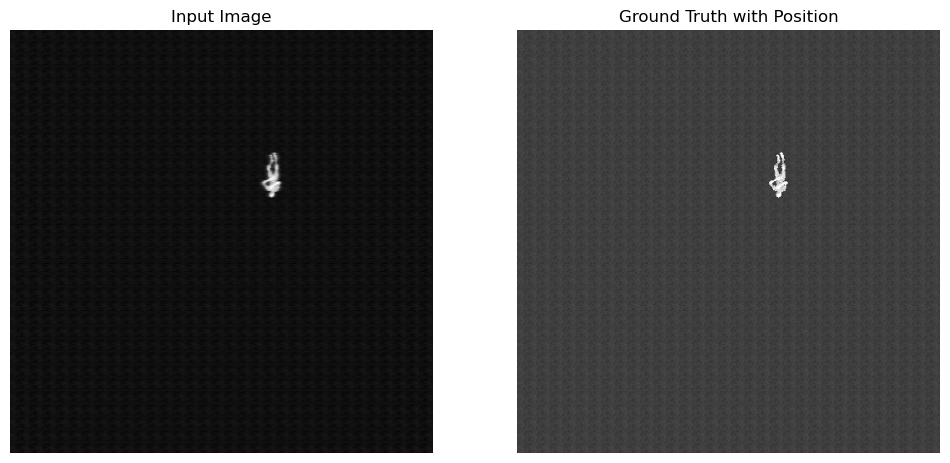

In [6]:
# Fetch and plot a batch of data
images, ground_truths, positions = next(iter(transformed_dataloader))
plot_images(images[0], ground_truths[0], positions[0])

In [7]:
images.shape, ground_truths.shape, positions

(torch.Size([1, 1, 512, 512]),
 torch.Size([1, 1, 512, 512]),
 [tensor([319]), tensor([180])])

## Custom Loss function

We have no data on the positions yet.

In [ ]:
class WeightedMSELoss(nn.Module):
    def __init__(self, position, radius, shape, high_weight=1.0, low_weight=0.1):
        super().__init__()
        self.position = position  # Coordinates of the person
        self.radius = radius      # Radius for ROI
        self.shape = shape        # Shape of the input tensor (height, width)
        self.high_weight = high_weight
        self.low_weight = low_weight

    def forward(self, input, target):
        # Create weight map
        weight_map = torch.full(self.shape, self.low_weight, device=input.device)

        # Apply high weight to the region around the person
        # This example assumes a simple square region for simplicity
        x, y = self.position
        weight_map[y-self.radius:y+self.radius, x-self.radius:x+self.radius] = self.high_weight

        # Compute weighted MSE loss
        squared_error = (input - target) ** 2
        weighted_squared_error = squared_error * weight_map
        loss = weighted_squared_error.mean()

        return loss

## Load SwinIR model

In [9]:
from swinir import SwinIR

In [10]:
# Correct dimensions for your input images
height, width = 512, 512

# Initialize SwinIR for 512x512 images with no upscaling
img_size = (height, width)
upscale = 1
window_size = 8  # Make sure this is a divisor of 512

# Reduced model parameters
embed_dim = 48  # Reduced from 96
depths = [6, 6, 6, 6] # [4, 4, 4, 4]  # Reduced from [6, 6, 6, 6]
num_heads = [6, 6, 6, 6] # [4, 4, 4, 4]  # Reduced from [6, 6, 6, 6]

model = SwinIR(
    img_size=img_size,
    patch_size=1,
    in_chans=1,
    embed_dim=embed_dim,
    depths=depths,
    num_heads=num_heads,
    window_size=window_size,
    mlp_ratio=4.,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=True,  # Enable checkpointing
    upscale=upscale,
    img_range=1.,
    upsampler='',
    resi_connection='1conv'
)

if torch.cuda.is_available():
    model = model.cuda().half()  # Using FP16

# Process image patches
patch_size = 256  # Example patch size
# Code to process image patches goes here


# Print model information (optional)
# print(model)

print("Model initialized with image size:", height, "x", width)

# Test the model with a dummy input
x = torch.randn((1, 1, height, width)).half()

if torch.cuda.is_available():
    model = model.cuda().half()
    x = x.cuda()

# Forward pass through the model
output = model(x)
print("Output shape:", output.shape)

Model initialized with image size: 512 x 512
Output shape: torch.Size([1, 1, 512, 512])


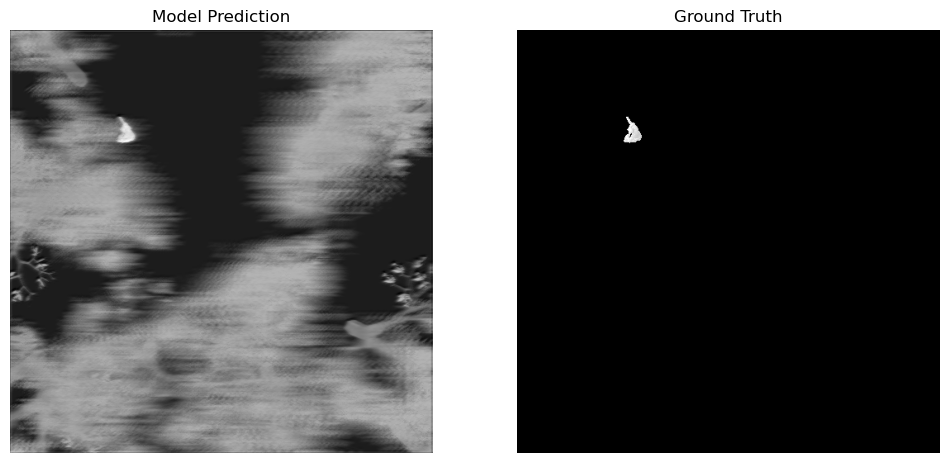

In [11]:
# Assuming transformed_dataloader is your DataLoader
# Fetch one batch of data
data_iterator = iter(transformed_dataloader)
images, ground_truths, positions = next(data_iterator)

# Check if CUDA is available and move the data to GPU if it is
if torch.cuda.is_available():
    images = images.cuda().half()  # Convert to half precision and move to GPU

# Forward pass through the model
with torch.no_grad():
    model.eval()  # Set the model to evaluation mode
    output = model(images)

# Convert output back to CPU and float32 for further processing if needed
output = output.cpu().float()

def plot_prediction_truth(prediction, truth):
    # Convert tensors to numpy arrays for plotting
    prediction_np = prediction.squeeze().numpy()
    truth_np = truth.squeeze().numpy()

    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Plot prediction
    axes[0].imshow(prediction_np, cmap='gray')
    axes[0].set_title('Model Prediction')
    axes[0].axis('off')

    # Plot ground truth
    axes[1].imshow(truth_np, cmap='gray')
    axes[1].set_title('Ground Truth')
    axes[1].axis('off')

    plt.show()

# Select the first image in the batch for demonstration
first_output = output[0]
first_ground_truth = ground_truths[0]

# Plotting
plot_prediction_truth(first_output, first_ground_truth)

## Model Training

In [12]:
# Check for available device: GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [13]:
import logging
import os

# Create folders
os.makedirs("logs", exist_ok=True)
os.makedirs("models", exist_ok=True)

# Setup logging
logging.basicConfig(filename="logs/swinir_2024-01-14_log.txt", level=logging.INFO)

# Check for available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

In [14]:
train_size_perc = 0.9

# Splitting the dataset
dataset = TransformedSingleImageDataset(path='./swinir_data', normalize=True, data_transform=True)
train_size = int(train_size_perc * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

# Correct dimensions for your input images
height, width = 512, 512

# Initialize SwinIR for 512x512 images with no upscaling
img_size = (height, width)
upscale = 1
window_size = 8  # Make sure this is a divisor of 512

# Reduced model parameters
embed_dim = 48  # Reduced from 96
depths = [6, 6, 6, 6] # [4, 4, 4, 4]  # Reduced from [6, 6, 6, 6]
num_heads = [6, 6, 6, 6] # [4, 4, 4, 4]  # Reduced from [6, 6, 6, 6]

model = SwinIR(
    img_size=img_size,
    patch_size=1,
    in_chans=1,
    embed_dim=embed_dim,
    depths=depths,
    num_heads=num_heads,
    window_size=window_size,
    mlp_ratio=4.,
    qkv_bias=True,
    qk_scale=None,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=True,  # Enable checkpointing
    upscale=upscale,
    img_range=1.,
    upsampler='',
    resi_connection='1conv'
).to(device)  # Initialize your model and move to the chosen device

loss_fn = nn.MSELoss().to(device)  # Move loss function to the chosen device
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Log hyperparameters
logging.info(f"Model Hyperparameters: {model}")

In [8]:
from skimage.metrics import peak_signal_noise_ratio as psnr
from skimage.metrics import structural_similarity as ssim
from torchvision.utils import save_image

def evaluate(model, dataloader):
    model.eval()
    total_psnr, total_ssim, total_loss = 0, 0, 0
    with torch.no_grad():
        for images, ground_truths, _ in dataloader:
            images, ground_truths = images.to(device), ground_truths.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, ground_truths)
            total_loss += loss.item()

            # Converting tensors to numpy arrays
            outputs_np = outputs.cpu().numpy()
            ground_truths_np = ground_truths.cpu().numpy()

            # Calculating PSNR and SSIM for each image in the batch
            for output, ground_truth in zip(outputs_np, ground_truths_np):
                total_psnr += psnr(ground_truth, output, data_range=output.max() - output.min())

    avg_psnr = total_psnr / (len(dataloader) * dataloader.batch_size)
    avg_loss = total_loss / len(dataloader)
    
    return avg_loss, avg_psnr


def save_tensor_as_image(tensor, filename):
    """
    Saves a tensor as an image file.
    Args:
        tensor: PyTorch tensor to save as an image.
        filename: Filename for the saved image.
    """
    if not os.path.exists(os.path.dirname(filename)):
        os.makedirs(os.path.dirname(filename))
    save_image(tensor, filename)


def save_validation_samples(model, dataloader, epoch, device,
                            output_folder='swin_predictions', save_images_limit=10,
                            include_inp_and_gt=False):
    model.eval()
    save_images_counter = 0
    for i, (images, ground_truths, _) in enumerate(dataloader):
        images, ground_truths = images.to(device), ground_truths.to(device)
        
        with torch.no_grad():
            outputs = model(images)

        # Save specified number of validation samples
        for j in range(images.size(0)):
            id = save_images_counter
            
            if include_inp_and_gt:
                save_tensor_as_image(images[j].cpu(), f'{output_folder}/{id}_epoch_{epoch}_inp.png')
                save_tensor_as_image(ground_truths[j].cpu(), f'{output_folder}/{id}_epoch_{epoch}_gt.png')
                
            save_tensor_as_image(outputs[j].cpu(), f'{output_folder}/{id}_epoch_{epoch}_pred.png')
            save_images_counter += 1

            if save_images_counter >= save_images_limit:
                break

        if save_images_counter >= save_images_limit:
            break

In [15]:
# Save Model
torch.save(model.state_dict(), f"models/swinir_2024-01-14_epoch_0.pth")

# Save initial validation samples before starting training
save_validation_samples(model, val_loader, 0, device, include_inp_and_gt=False)

In [16]:
start_time = time.time()

# Initial Evaluation
init_loss, init_psnr = evaluate(model, val_loader)
end_time = time.time()

print_statement = f"Initial - Validation Time: {end_time - start_time} seconds"
print(print_statement)
logging.info(print_statement)

print_statement = f"Initial - Performance Loss: {init_loss}, PSNR: {init_psnr}"
print(print_statement)
logging.info(print_statement)

Initial - Validation Time: 176.5231635570526 seconds
Initial - Performance Loss: 0.2884598687143609, PSNR: 7.006818160041714


In [17]:
# Assuming model, train_loader, val_loader, optimizer, loss_fn, device, and logging are defined
num_epochs = 300
accumulation_steps = 4  # Set this based on your requirement
scaler = GradScaler()

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    optimizer.zero_grad()  # Initialize gradients to zero at the start of an epoch

    for i, (images, ground_truths, _) in enumerate(train_loader):
        images, ground_truths = images.to(device), ground_truths.to(device)
        
        if (i+1)%10 == 0:
            print(f'Processing Epoch: {epoch+1}, Batch: {i+1}')
        
        # Run the forward pass with automatic mixed precision
        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, ground_truths)
            loss = loss / accumulation_steps  # Normalize our loss (if averaged)

        # Scales the loss and calls backward to create scaled gradients
        scaler.scale(loss).backward()

        if (i+1) % accumulation_steps == 0:  # Perform optimization step
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()  # Clear gradients for the next set of batches
        
        if i == 100:
            break  # Remove this break in your actual training
        
    
    end_time = time.time()

    print_statement = f"Epoch {epoch+1}/{num_epochs} - Training Time: {end_time - start_time} seconds"
    print(print_statement)
    logging.info(print_statement)

    # Validation
    val_loss, val_psnr = evaluate(model, val_loader)
    
    # Save images for this epoch
    save_validation_samples(model, val_loader, epoch + 1, device)
    
    print_statement = f"Epoch {epoch+1} Validation - Loss: {val_loss}, PSNR: {val_psnr}"
    print(print_statement)
    logging.info(print_statement)

    # Save Model
    torch.save(model.state_dict(), f"models/swinir_2024-01-14_epoch_{epoch+1}.pth")

logging.info("Training completed")

Processing Epoch: 1, Batch: 10
Processing Epoch: 1, Batch: 20
Processing Epoch: 1, Batch: 30
Processing Epoch: 1, Batch: 40
Processing Epoch: 1, Batch: 50
Processing Epoch: 1, Batch: 60
Processing Epoch: 1, Batch: 70
Processing Epoch: 1, Batch: 80
Processing Epoch: 1, Batch: 90
Processing Epoch: 1, Batch: 100
Epoch 1/300 - Training Time: 4927.959180355072 seconds
Epoch 1 Validation - Loss: 0.05148929892347591, PSNR: 12.91580380895575
Processing Epoch: 2, Batch: 10
Processing Epoch: 2, Batch: 20
Processing Epoch: 2, Batch: 30
Processing Epoch: 2, Batch: 40
Processing Epoch: 2, Batch: 50
Processing Epoch: 2, Batch: 60
Processing Epoch: 2, Batch: 70
Processing Epoch: 2, Batch: 80
Processing Epoch: 2, Batch: 90
Processing Epoch: 2, Batch: 100
Epoch 2/300 - Training Time: 4705.326467037201 seconds
Epoch 2 Validation - Loss: 0.04027960671683644, PSNR: 13.988974342988891
Processing Epoch: 3, Batch: 10
Processing Epoch: 3, Batch: 20
Processing Epoch: 3, Batch: 30
Processing Epoch: 3, Batch: 40

KeyboardInterrupt: 

In [18]:
start_time = time.time()

# Initial Evaluation
init_loss, init_psnr = evaluate(model, val_loader)
end_time = time.time()

print_statement = f"Initial - Validation Time: {end_time - start_time} seconds"
print(print_statement)

print_statement = f"Initial - Performance Loss: {init_loss}, PSNR: {init_psnr}"
print(print_statement)

Initial - Validation Time: 181.70958471298218 seconds
Initial - Performance Loss: 0.039955352573646324, PSNR: 13.604168005804224


In [19]:
# Save Model
# torch.save(model.state_dict(), f"models/swinir_2024-01-14_last_updata.pth")

### SwinIR V2

In [9]:
from swin2sr import Swin2SR

In [10]:
# Check for available device: GPU if available, else CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device: {device}")

device: cuda


In [11]:
train_size_perc = 0.9

# Splitting the dataset
dataset = TransformedSingleImageDataset(path='./swinir_data', normalize=True, data_transform=False)
train_size = int(train_size_perc * len(dataset))
val_size = len(dataset) - train_size

# Define train and validation datasets without random split
train_dataset = Subset(dataset, range(0, train_size))
val_dataset = Subset(dataset, range(train_size, len(dataset)))

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

In [12]:
train_size_perc = 0.9

# Splitting the dataset
dataset = TransformedSingleImageDataset(path='./swinir_data', normalize=True, data_transform=True)
train_size = int(train_size_perc * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Creating DataLoaders
train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, num_workers=0)

# Correct dimensions for your input images
height, width = 512, 512

# Initialize SwinIR for 512x512 images with no upscaling
img_size = (height, width)
upscale = 1
window_size = 8  # Make sure this is a divisor of 512

# Correct dimensions for your input images
height, width = 512, 512

# Initialize SwinIR for 512x512 images with no upscaling
img_size = (height, width)
upscale = 1
window_size = 8  # Make sure this is a divisor of 512

# Reduced model parameters
embed_dim = 96  # Reduced from 96
depths = [6, 6] # 6, 6] # [4, 4, 4, 4]  # Reduced from [6, 6, 6, 6]
num_heads = [6, 6] # 6, 6] # [4, 4, 4, 4]  # Reduced from [6, 6, 6, 6]

In [13]:
model = Swin2SR(
    img_size=img_size,
    patch_size=1,
    in_chans=1,
    embed_dim=embed_dim,
    depths=depths,
    num_heads=num_heads,
    window_size=window_size,
    mlp_ratio=4.,
    qkv_bias=True,
    # qk_scale=None,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=True,  # Enable checkpointing
    upscale=upscale,
    img_range=1.,
    upsampler='',
    resi_connection='1conv'
).to(device)  # Initialize your model and move to the chosen device

loss_fn = nn.MSELoss().to(device)  # Move loss function to the chosen device
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
# Create folders
os.makedirs("logs/swinirv2", exist_ok=True)
os.makedirs("models/swinirv2", exist_ok=True)

# Setup logging
logging.basicConfig(filename="logs/logs_swinirv2/swinirv2_2024-01-15_log.txt", level=logging.INFO)

# Check for available device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
logging.info(f"Using device: {device}")

In [15]:
model_str_log = f'''
Swin2SR(
    img_size={img_size},
    patch_size=1,
    in_chans=1,
    embed_dim={embed_dim},
    depths={depths},
    num_heads={num_heads},
    window_size={window_size},
    mlp_ratio=4.,
    qkv_bias=True,
    # qk_scale=None,
    drop_rate=0.,
    attn_drop_rate=0.,
    drop_path_rate=0.1,
    norm_layer=nn.LayerNorm,
    ape=False,
    patch_norm=True,
    use_checkpoint=True,  # Enable checkpointing
    upscale=upscale,
    img_range=1.,
    upsampler='',
    resi_connection='1conv'
)
'''

model_str_log

"\nSwin2SR(\n    img_size=(512, 512),\n    patch_size=1,\n    in_chans=1,\n    embed_dim=96,\n    depths=[6, 6],\n    num_heads=[6, 6],\n    window_size=8,\n    mlp_ratio=4.,\n    qkv_bias=True,\n    # qk_scale=None,\n    drop_rate=0.,\n    attn_drop_rate=0.,\n    drop_path_rate=0.1,\n    norm_layer=nn.LayerNorm,\n    ape=False,\n    patch_norm=True,\n    use_checkpoint=True,  # Enable checkpointing\n    upscale=upscale,\n    img_range=1.,\n    upsampler='',\n    resi_connection='1conv'\n)\n"

In [16]:
# Log hyperparameters
logging.info(model_str_log)

In [17]:
# Save Model
torch.save(model.state_dict(), f"models/swinirv2/swinirv2_2024-01-15_epoch_0.pth")

# Save initial validation samples before starting training
save_validation_samples(model, val_loader, 0, device, include_inp_and_gt=False)

In [18]:
start_time = time.time()

# Initial Evaluation
init_loss, init_psnr = evaluate(model, val_loader)
end_time = time.time()

print_statement = f"Initial - Validation Time: {end_time - start_time} seconds"
print(print_statement)
logging.info(print_statement)

print_statement = f"Initial - Performance Loss: {init_loss}, PSNR: {init_psnr}"
print(print_statement)
logging.info(print_statement)

Initial - Validation Time: 272.9422216415405 seconds
Initial - Performance Loss: 0.39490192981049566, PSNR: 8.627262979814342


In [19]:
# Assuming model, train_loader, val_loader, optimizer, loss_fn, device, and logging are defined
num_epochs = 300
accumulation_steps = 4  # Set this based on your requirement
scaler = GradScaler()

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    optimizer.zero_grad()  # Initialize gradients to zero at the start of an epoch

    for i, (images, ground_truths, _) in enumerate(train_loader):
        images, ground_truths = images.to(device), ground_truths.to(device)
        
        if (i+1)%10 == 0:
            print(f'Processing Epoch: {epoch+1}, Batch: {i+1}')
        
        # Run the forward pass with automatic mixed precision
        with autocast():
            outputs = model(images)
            loss = loss_fn(outputs, ground_truths)
            loss = loss / accumulation_steps  # Normalize our loss (if averaged)

        # Scales the loss and calls backward to create scaled gradients
        scaler.scale(loss).backward()

        if (i+1) % accumulation_steps == 0:  # Perform optimization step
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()  # Clear gradients for the next set of batches
        
        if i == 100:
            break  # Remove this break in your actual training
    
    end_time = time.time()

    print_statement = f"Epoch {epoch+1}/{num_epochs} - Training Time: {end_time - start_time} seconds"
    print(print_statement)
    logging.info(print_statement)

    # Validation
    val_loss, val_psnr = evaluate(model, val_loader)
    
    # Save images for this epoch
    save_validation_samples(model, val_loader, epoch + 1, device, output_folder='swin_predictions/swinirv2')
    
    print_statement = f"Epoch {epoch+1} Validation - Loss: {val_loss}, PSNR: {val_psnr}"
    print(print_statement)
    logging.info(print_statement)

    # Save Model
    torch.save(model.state_dict(), f"models/swinirv2/swinirv2_2024-01-14_epoch_{epoch+1}.pth")

logging.info("Training completed")

Processing Epoch: 1, Batch: 10


KeyboardInterrupt: 